In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jax_canoak.subjects.utils import es as fes
from jax_canoak.shared_utilities.forcings.get_forcing import get_modis

%load_ext autoreload
%autoreload 2

In [18]:
dir_data = Path("../data/fluxtower/US-Hn1")
f_forcing = dir_data / "US-Hn1.csv"
f_chamber = dir_data / "Hn1_chamber.csv"

In [31]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [32]:
# Vegetation height
# Sagebrush: ~1.2m https://workbasedlearning.pnnl.gov/pals/resource/cards/sagebrush.stm
df["veg_ht"] = 1.2

In [33]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y-%m-%d %H:%M:%S")

<Axes: xlabel='TIMESTAMP_END'>

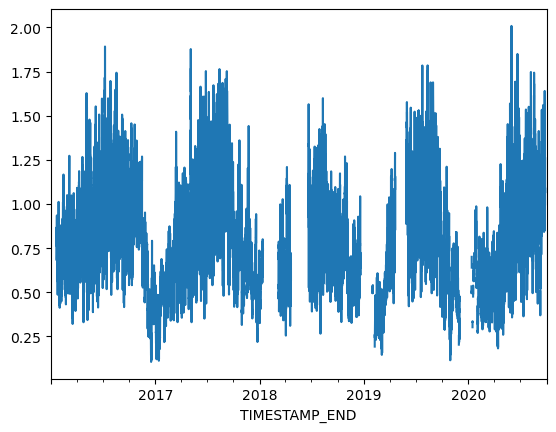

In [34]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["Tair"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["rH"] = np.clip(df["rH"], a_max=100, a_min=0)
ea = es * df["rH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

<Axes: >

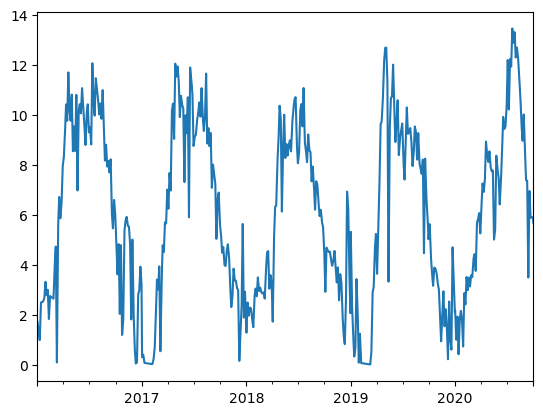

In [35]:
# Get MODIS LAI
start, end = df.index[0], df.index[-1]
df_modis = get_modis("US-Hn1", start, end, sample_freq="30min")
df_modis["LAI"].plot()

In [36]:
# Combine df_modis to df
df = df.join(df_modis)

In [37]:
# Get soil respiration
df_chamber = pd.read_csv(f_chamber)
df_chamber["Timestamp"] = pd.to_datetime(
    df_chamber["Timestamp"], format="%Y-%m-%d %H:%M:%S"
)
df_chamber.set_index("Timestamp", inplace=True)
df_chamber = df_chamber.resample("30T").mean()
df = df.join(df_chamber[["Rsoil"]])

In [15]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "Tair",
    "Rg",
    "eair",
    "WS_x",
    "CO2",
    "PA",
    "Ustar",
    "TS_15cm",
    "SWC_15cm",
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

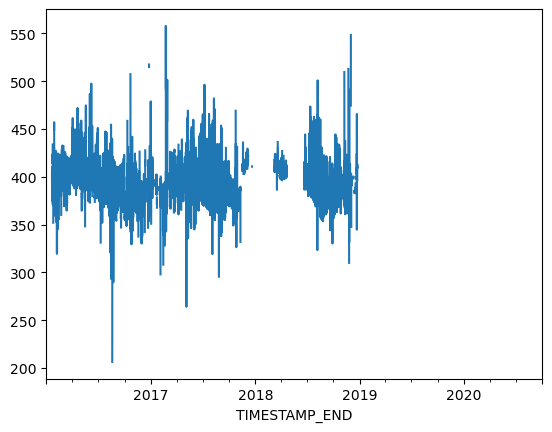

In [16]:
# Clean up the negative CO2 ppm
df.loc[df["CO2"] <= 100, "CO2"] = np.nan
df["CO2"].plot()

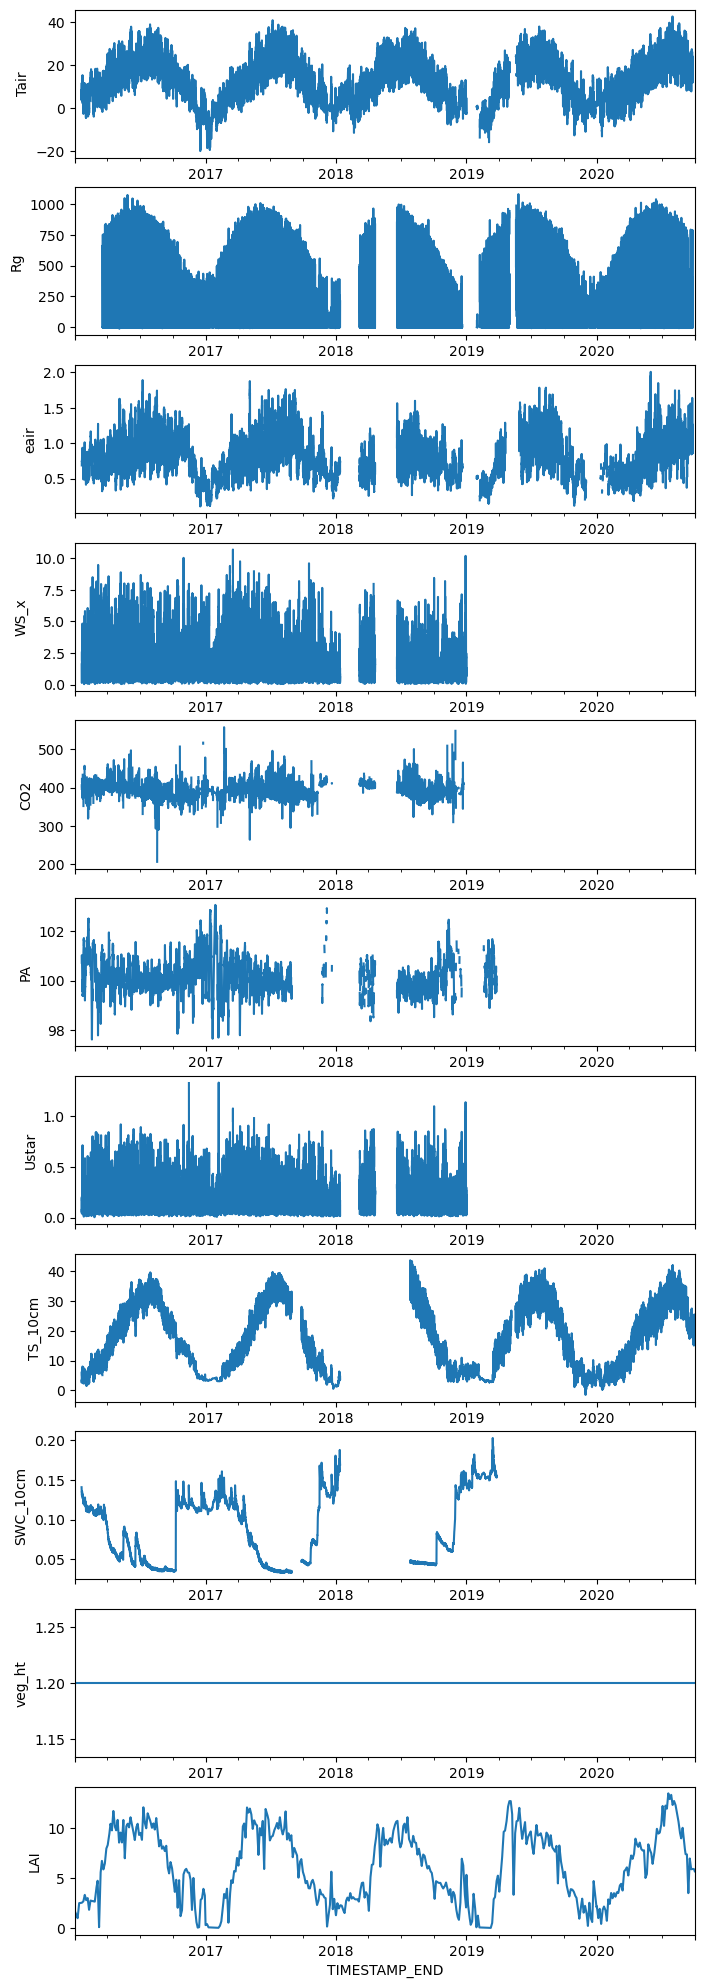

In [17]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25))
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [33]:
# Save the forcing data
start, end = "2016-06-01", "2017-06-30"
df_save = df[in_varns][start:end]
df_save.interpolate(inplace=True)
np.savetxt(dir_data / "US-Hn1-forcings.csv", df_save.values, delimiter=",")

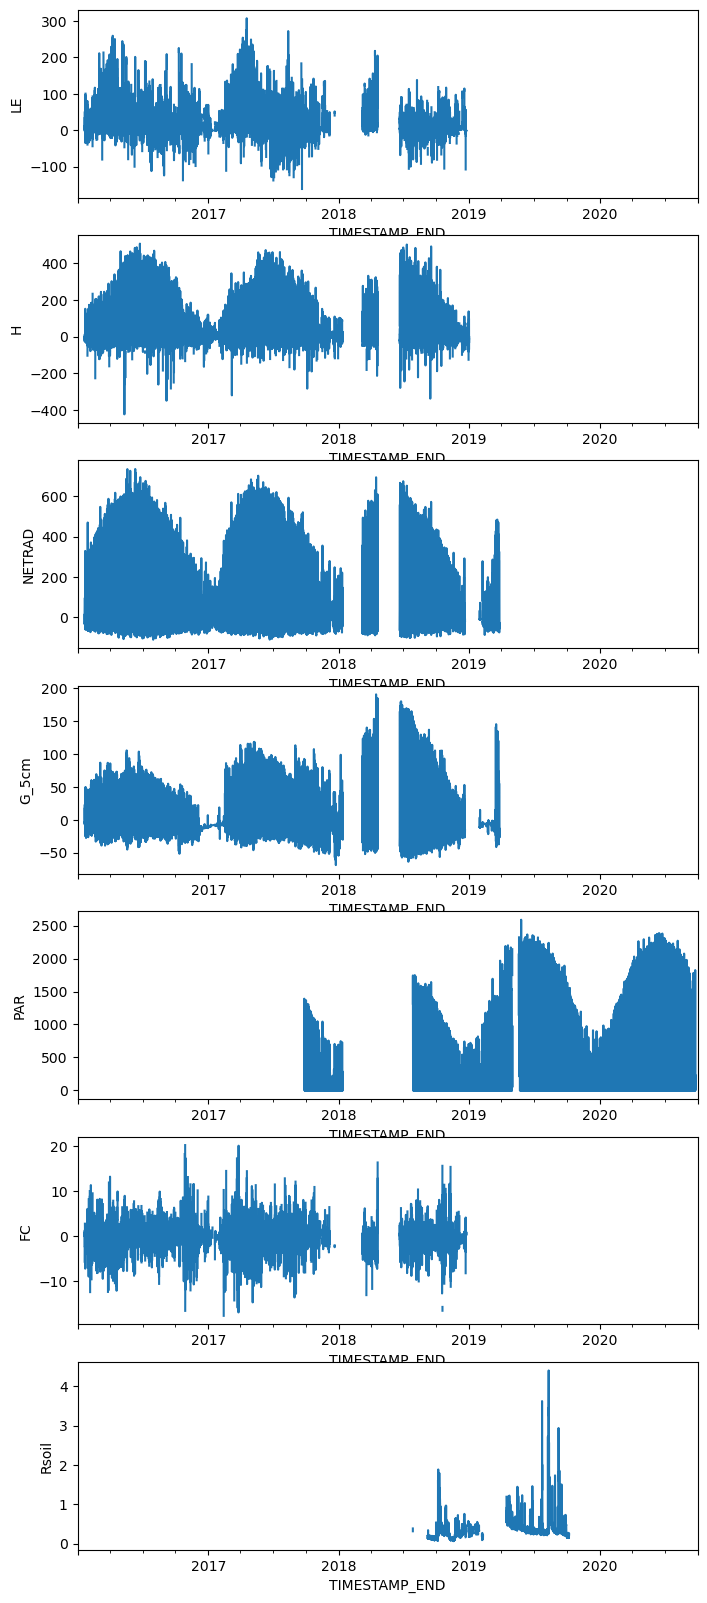

In [38]:
# The data to compare
out_varns = ["LE", "H", "NETRAD", "G_5cm", "PAR", "FC", "Rsoil"]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20))
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

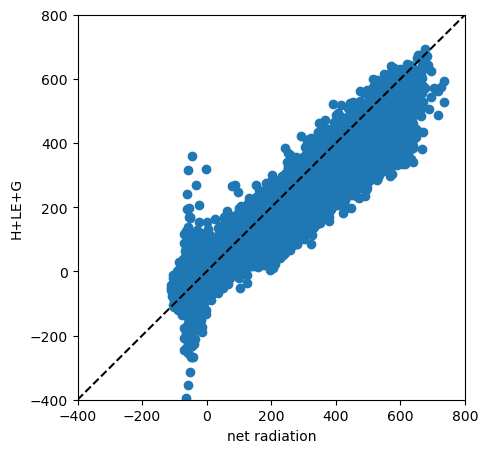

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df["NETRAD"], df["H"] + df["LE"] + df["G_5cm"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [26]:
# Save the data to compare
df_save = df[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
df_save.to_csv(dir_data / "US-Hn1-fluxes.csv", sep=",")